## Dependencies

- Sci-kit learn
- NumPy 
- SciPy



In [1]:
import numpy as np
from os.path import join
from os import listdir
import matplotlib.pyplot as plt
import warnings
from modules.utils import return_metrics,flat_list,get_significance,confusion_matrix
#stat tools
from scipy.stats import pearsonr#2 continuous variable
from scipy.stats import spearmanr#1 binary and 1 continuous variable
from scipy.stats import ttest_ind
from scipy.stats import bartlett
from scipy.stats import shapiro
#machine learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression



## Utils

`utils.py` contains misc. utilitaries such as measures and task dictionaries, confusion matrix.

## Data
### Download
#### Command-line
To get the data you can run the following commands from the `data` directory :
```
mkdir NewHandPD
cd NewHandPD/

#download healthy data
mkdir Healthy
cd Healthy/
wget http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewHealthy/Signal.zip
unzip Signal.zip
cd ..

#download Patients data
mkdir Patients
cd Patients/
wget http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewPatients/Signal.zip
unzip Signal.zip
```
#### Graphic interface
You can get the data from [here](http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/), under "The NewHandPD dataset" you will find :
- [Healthy Signals](http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewHealthy/Signal.zip)
- [Patient Signals](http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewPatients/Signal.zip)

The data should be placed like this :  
```
data
└───NewHandPD
│   └───Healthy
│   │   └───Signal
│   │   │   │   *.txt
│   └───Patients
│   │   └───Signal
│   │   │   │   *.txt
```

### Correct it /!\ Mandatory /!\
Healthy's `SigMea1-28` is not properly named it should be `SigMea1-H28`, rename it before running the rest of this code !

Healthy `sigDiaA-H34.txt` age was set at 50 but in all other tasks it was set at 40 so I set it to 40, do it as well before running the rest of the code ! See :  
circA-H34.txt 40 circB-H34.txt 40 sigDiaB-H34.txt 40 sigMea1-H34.txt 40 sigMea2-H34.txt 40 sigMea3-H34.txt 40 sigMea4-H34.txt 40 sigSp1-H34.txt 40 sigSp2-H34.txt 40 sigSp3-H34.txt 40 sigSp4-H34.txt 40

In [2]:
index2measure=["CH1: Microphone",
"CH 2: Fingergrip",
"CH 3: Axial Pressure of ink Refill",
"CH 4: Tilt and Acceleration in X direction",
"CH 5: Tilt and Acceleration in Y direction",
"CH 6: Tilt and Acceleration Z direction"]


def load_NewHandPD(group,data,ages,load_task):
    data_path=join("data","NewHandPD",group,"Signal")
    task_path=listdir(data_path)
    task_path.sort()
    counter=0
    for task in task_path:
        print("group {}, subject {}".format(group,counter),end="\r")
        task_name=''.join(i for i in task.split("-")[0])
        if task_name == load_task:
            path=join(data_path,task)
            with open(path) as file:
                raw_line=file.readlines()[2]
                age=int(''.join(i for i in raw_line if i.isdigit()))
                ages.append(age)
            data.append(np.loadtxt(path, dtype=float, skiprows=17,delimiter="\t"))
            counter+=1
    if group == "Patients":
        assert counter==31
    else:
        assert counter==35

task_names=["circA","circB","sigDiaA","sigDiaB","sigMea1","sigMea2","sigMea3","sigMea4","sigSp1","sigSp2","sigSp3","sigSp4"]


data=[]
load_task=task_names[:]
n_tasks=len(load_task)
ages=[]

print("You should first load Patients then Healthy, else your targets will be wrong !")
print("loading may take up to several minutes")
for task_name in load_task:
    task=[]
    task_age=[]
    load_NewHandPD("Patients",task,task_age,task_name)
    load_NewHandPD("Healthy",task,task_age,task_name)
    ages.append(task_age)
    data.append(task)
targets=[1 for _ in range(31)]+[0 for _ in range(35)]
lengths=[[len(subject) for subject in task]for task in data]

subject_ages=np.mean(ages,axis=0)
subjects_lengths=np.mean(lengths,axis=0)
spiral_lengths=lengths[-4:]
meanders_lengths=lengths[-8:-4]
flat_ages=np.asarray(ages).T.reshape(-1)
flat_lengths=np.asarray(lengths).T.reshape(-1)
median=np.median(subjects_lengths)
print("succesfully loaded tasks",load_task)
print("12 tasks, 66 subjects, 66 targets")
print(len(data),len(data[0]),len(targets))

You should first load Patients then Healthy, else your targets will be wrong !
loading may take several minutes
succesfully loaded tasks ['circA', 'circB', 'sigDiaA', 'sigDiaB', 'sigMea1', 'sigMea2', 'sigMea3', 'sigMea4', 'sigSp1', 'sigSp2', 'sigSp3', 'sigSp4']
12 tasks, 66 subjects, 66 targets
12 66 66


# Correlation
## between task length and subject's ages

task | person correlation coefficient | p-value
--|--|--
circA |0.2781 | 0.0238 
circB |0.2533 | 0.0401 
sigDiaA |0.2099 | 0.0907 
sigDiaB |0.2073 | 0.0948 
sigMea1 |0.3822 | 0.0015 
sigMea2 |0.3728 | 0.0021 
sigMea3 |0.3265 | 0.0075 
sigMea4 |0.3226 | 0.0082 
sigSp1 |0.3079 | 0.0119 
sigSp2 |0.3242 | 0.0079 
sigSp3 |0.3169 | 0.0095 
sigSp4 |0.3292 | 0.0070 
 meanders|0.3619 | 0.0028 
spirals|0.3346 | 0.0060 
 all|0.3512 | 0.0038 




In [6]:
corr, p = pearsonr(np.mean(meanders_lengths,axis=0),subject_ages)
print(" |{:.4f} | {:.4f} ".format(corr, p ))

for i,task in enumerate(task_names):
    print(task,end="")
    corr, p = pearsonr(lengths[i],subject_ages)
    print(" |{:.4f} | {:.4f} ".format(corr, p ))

 |0.3619 | 0.0028 
circA |0.2781 | 0.0238 
circB |0.2533 | 0.0401 
sigDiaA |0.2099 | 0.0907 
sigDiaB |0.2073 | 0.0948 
sigMea1 |0.3822 | 0.0015 
sigMea2 |0.3728 | 0.0021 
sigMea3 |0.3265 | 0.0075 
sigMea4 |0.3226 | 0.0082 
sigSp1 |0.3079 | 0.0119 
sigSp2 |0.3242 | 0.0079 
sigSp3 |0.3169 | 0.0095 
sigSp4 |0.3292 | 0.0070 


## between task length and targets
### t-test

In [13]:
for i,task in enumerate(task_names):
    print(task,end="")
    
    patients_shapiro = shapiro(lengths[i][:31])

    control_shapiro=shapiro(lengths[i][31:])

    bartlett_=bartlett(lengths[i][:31],lengths[i][31:])
    corr, p = ttest_ind(lengths[i][:31],lengths[i][31:])
    significance=get_significance(p)
    print(" |{:.4f} | {:.3e} |{} | {:.4f}| {:.3e}| {:.4f}| {:.3e}| {:.4f}| {:.3e}".format(corr, p ,significance,
        bartlett_[0],bartlett_[1],patients_shapiro[0],patients_shapiro[1],control_shapiro[0],control_shapiro[1]))

circA |6.1612 | 5.361e-08 |*** | 41.6507| 1.091e-10| 0.8267| 1.681e-04| 0.9141| 9.653e-03
circB |5.9077 | 1.457e-07 |*** | 29.1653| 6.646e-08| 0.8071| 7.013e-05| 0.9230| 1.747e-02
sigDiaA |4.5606 | 2.362e-05 |*** | 2.5943| 1.073e-01| 0.6461| 2.036e-07| 0.7872| 1.155e-05
sigDiaB |3.8808 | 2.487e-04 |*** | 6.5721| 1.036e-02| 0.9266| 3.544e-02| 0.7973| 1.809e-05
sigMea1 |7.0343 | 1.620e-09 |*** | 19.7789| 8.694e-06| 0.9505| 1.616e-01| 0.9115| 8.176e-03
sigMea2 |6.1659 | 5.261e-08 |*** | 23.1749| 1.479e-06| 0.9353| 6.133e-02| 0.9613| 2.504e-01
sigMea3 |6.0783 | 7.441e-08 |*** | 34.8137| 3.628e-09| 0.9233| 2.890e-02| 0.9104| 7.625e-03
sigMea4 |5.4570 | 8.386e-07 |*** | 31.5947| 1.899e-08| 0.9307| 4.572e-02| 0.9484| 1.015e-01
sigSp1 |5.2307 | 1.987e-06 |*** | 21.4812| 3.573e-06| 0.7893| 3.286e-05| 0.8780| 1.068e-03
sigSp2 |5.5963 | 4.902e-07 |*** | 39.2744| 3.682e-10| 0.8501| 5.089e-04| 0.9826| 8.393e-01
sigSp3 |6.5541 | 1.120e-08 |*** | 26.0317| 3.359e-07| 0.9555| 2.203e-01| 0.9629| 2.793e-

In [14]:

patients_shapiro = shapiro(np.mean(spiral_lengths,axis=0)[:31])#subjects_lengths[:31])

control_shapiro=shapiro(np.mean(spiral_lengths,axis=0)[31:])#np.mean(meanders_lengths,axis=0)[31:])

bartlett_=bartlett(np.mean(spiral_lengths,axis=0)[:31],np.mean(spiral_lengths,axis=0)[31:])
corr, p = ttest_ind(np.mean(spiral_lengths,axis=0)[:31],np.mean(spiral_lengths,axis=0)[31:])
significance=get_significance(p)
print(" |{:.4f} | {:.3e} |{} | {:.4f}| {:.3e}| {:.4f}| {:.3e}| {:.4f}| {:.3e}".format(corr, p ,significance,
    bartlett_[0],bartlett_[1],patients_shapiro[0],patients_shapiro[1],control_shapiro[0],control_shapiro[1]))

 |6.2149 | 4.332e-08 |*** | 28.2988| 1.040e-07| 0.9127| 1.520e-02| 0.9431| 6.940e-02


task | t-statistic | t p-value | significance| bartlett statistic | bartlett p-value | patients_shapiro statistic | patients_shapiro  p-value| control_shapiro statistic| control_shapiro p-value
--|--|--|--|--|--|--|--|--|--
circA |6.1612 | 5.361e-08 |*** | 41.6507| 1.091e-10| 0.8267| 1.681e-04| 0.9141| 9.653e-03
circB |5.9077 | 1.457e-07 |*** | 29.1653| 6.646e-08| 0.8071| 7.013e-05| 0.9230| 1.747e-02
sigDiaA |4.5606 | 2.362e-05 |*** | 2.5943| 1.073e-01| 0.6461| 2.036e-07| 0.7872| 1.155e-05
sigDiaB |3.8808 | 2.487e-04 |*** | 6.5721| 1.036e-02| 0.9266| 3.544e-02| 0.7973| 1.809e-05
sigMea1 |7.0343 | 1.620e-09 |*** | 19.7789| 8.694e-06| 0.9505| 1.616e-01| 0.9115| 8.176e-03
sigMea2 |6.1659 | 5.261e-08 |*** | 23.1749| 1.479e-06| 0.9353| 6.133e-02| 0.9613| 2.504e-01
sigMea3 |6.0783 | 7.441e-08 |*** | 34.8137| 3.628e-09| 0.9233| 2.890e-02| 0.9104| 7.625e-03
sigMea4 |5.4570 | 8.386e-07 |*** | 31.5947| 1.899e-08| 0.9307| 4.572e-02| 0.9484| 1.015e-01
sigSp1 |5.2307 | 1.987e-06 |*** | 21.4812| 3.573e-06| 0.7893| 3.286e-05| 0.8780| 1.068e-03
sigSp2 |5.5963 | 4.902e-07 |*** | 39.2744| 3.682e-10| 0.8501| 5.089e-04| 0.9826| 8.393e-01
sigSp3 |6.5541 | 1.120e-08 |*** | 26.0317| 3.359e-07| 0.9555| 2.203e-01| 0.9629| 2.793e-01
sigSp4 |5.9191 | 1.393e-07 |*** | 30.3181| 3.667e-08| 0.9527| 1.850e-01| 0.9391| 5.239e-02
meanders |6.4848 | 1.478e-08 |*** | 27.4487| 1.613e-07| 0.9332| 5.376e-02| 0.9140| 9.641e-03
spirals |6.2149 | 4.332e-08 |*** | 28.2988| 1.040e-07| 0.9127| 1.520e-02| 0.9431| 6.940e-02
 all|7.2950 | 5.638e-10 |*** | 27.7071| 1.411e-07| 0.9291| 4.152e-02| 0.8912| 2.310e-03

### Spearman


In [15]:



for i,task in enumerate(task_names):
    print(task,end="")
    corr, p = spearmanr(lengths[i],targets)
    print(" |{:.4f} | {:.3e} ".format(corr, p ))

circA |0.7578 | 1.753e-13 
circB |0.7029 | 4.719e-11 
sigDiaA |0.6558 | 2.275e-09 
sigDiaB |0.5746 | 4.526e-07 
sigMea1 |0.6758 | 4.796e-10 
sigMea2 |0.6415 | 6.491e-09 
sigMea3 |0.6200 | 2.829e-08 
sigMea4 |0.5738 | 4.746e-07 
sigSp1 |0.6614 | 1.488e-09 
sigSp2 |0.6527 | 2.880e-09 
sigSp3 |0.6662 | 1.028e-09 
sigSp4 |0.6120 | 4.763e-08 


task | Spearman correlation coefficient | p-value
--|--|--
circA |0.7578 | 1.753e-13 
circB |0.7029 | 4.719e-11 
sigDiaA |0.6558 | 2.275e-09 
sigDiaB |0.5746 | 4.526e-07 
sigMea1 |0.6758 | 4.796e-10 
sigMea2 |0.6415 | 6.491e-09 
sigMea3 |0.6200 | 2.829e-08 
sigMea4 |0.5738 | 4.746e-07 
sigSp1 |0.6614 | 1.488e-09 
sigSp2 |0.6527 | 2.880e-09 
sigSp3 |0.6662 | 1.028e-09 
sigSp4 |0.6120 | 4.763e-08 
meanders|0.6510 | 3.251e-09 
 spirals|0.6638 | 1.240e-09 
all|0.7419 | 1.027e-12 

## between subject ages and targets 




### t-test

In [16]:
patients_shapiro = shapiro(subject_ages[:31])#subjects_lengths[:31])

control_shapiro=shapiro(subject_ages[31:])#np.mean(meanders_lengths,axis=0)[31:])

bartlett_=bartlett(subject_ages[:31],subject_ages[31:])
corr, p = ttest_ind(subject_ages[:31],subject_ages[31:])
significance=get_significance(p)
print(" |{:.4f} | {:.3e} |{} | {:.4f}| {:.3e}| {:.4f}| {:.3e}| {:.4f}| {:.3e}".format(corr, p ,significance,
    bartlett_[0],bartlett_[1],patients_shapiro[0],patients_shapiro[1],control_shapiro[0],control_shapiro[1]))

 |4.8582 | 7.996e-06 |*** | 14.8318| 1.175e-04| 0.9481| 1.380e-01| 0.9672| 3.723e-01


 t-statistic | t p-value | significance| bartlett statistic | bartlett p-value | patients_shapiro statistic | patients_shapiro  p-value| control_shapiro statistic| control_shapiro p-value
--|--|--|--|--|--|--|--|--
4.8582 | 7.996e-06 |*** | 14.8318| 1.175e-04| 0.9481| 1.380e-01| 0.9672| 3.723e-01

### Spearman


In [17]:
corr, p = spearmanr(subject_ages,targets)
print(" |{:.4f} | {:.3e} ".format(corr, p ))

 |0.5359 | 3.527e-06 


 Spearman correlation coefficient | p-value
--|--
0.5359 | 3.527e-06 

### Fatigue ?

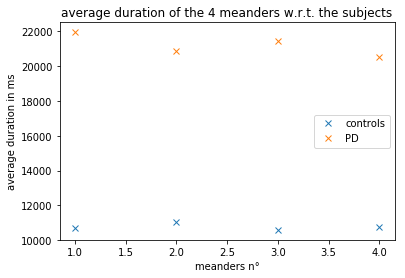

In [18]:
plt.title("average duration of the 4 meanders w.r.t. the subjects")
plt.ylabel("average duration in ms")
plt.plot([1,2,3,4],np.mean(np.asarray(meanders_lengths)[:,31:],axis=1),'x',label="controls")
plt.plot([1,2,3,4],np.mean(np.asarray(meanders_lengths)[:,:31],axis=1),'x',label="PD")
plt.xlabel("meanders n°")
plt.legend()

#  Classification

In [20]:
def rule_based(threshold,subjects_lengths=subjects_lengths):
    tp=len([i for i in subjects_lengths[:31] if i >threshold])
    fp=31-tp

    tn=len([i for i in subjects_lengths[31:] if i <=threshold])
    fn=35-tn
    accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
    results=""
    for metric in [accuracy,sensitivity,specificity,ppv,npv]:
        results+=" | {:.2f}".format(metric)
    print(results)

In [21]:
for i,task in enumerate(task_names):
    print(task,end="")
    rule_based(np.median(lengths[i]),lengths[i])

circA | 0.88 | 0.85 | 0.91 | 0.90 | 0.86
circB | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigDiaA | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigDiaB | 0.76 | 0.74 | 0.77 | 0.74 | 0.77
sigMea1 | 0.85 | 0.82 | 0.88 | 0.87 | 0.83
sigMea2 | 0.82 | 0.79 | 0.85 | 0.84 | 0.80
sigMea3 | 0.82 | 0.79 | 0.85 | 0.84 | 0.80
sigMea4 | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigSp1 | 0.80 | 0.78 | 0.82 | 0.81 | 0.80
sigSp2 | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigSp3 | 0.86 | 0.84 | 0.88 | 0.87 | 0.86
sigSp4 | 0.76 | 0.73 | 0.79 | 0.77 | 0.74


In [22]:
rule_based(np.median(np.mean(meanders_lengths,axis=0)),np.mean(meanders_lengths,axis=0))

 | 0.85 | 0.82 | 0.88 | 0.87 | 0.83


# 10-CV
## when setting threshold at median(subjects_lengths)



task|Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--|--
circA | 0.88 | 0.85 | 0.91 | 0.90 | 0.86
circB | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigDiaA | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigDiaB | 0.76 | 0.74 | 0.77 | 0.74 | 0.77
sigMea1 | 0.85 | 0.82 | 0.88 | 0.87 | 0.83
sigMea2 | 0.82 | 0.79 | 0.85 | 0.84 | 0.80
sigMea3 | 0.82 | 0.79 | 0.85 | 0.84 | 0.80
sigMea4 | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigSp1 | 0.80 | 0.78 | 0.82 | 0.81 | 0.80
sigSp2 | 0.79 | 0.76 | 0.82 | 0.81 | 0.77
sigSp3 | 0.86 | 0.84 | 0.88 | 0.87 | 0.86
sigSp4 | 0.76 | 0.73 | 0.79 | 0.77 | 0.74
sigMea_mean  | 0.85 | 0.82 | 0.88 | 0.87 | 0.83
sigSp_mean| 0.82 | 0.79 | 0.85 | 0.84 | 0.80
early fusion| 0.85 | 0.82 | 0.88 | 0.87 | 0.83

## With Linear discriminant analysis (see below)
### using exam duration

task|Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--|--
circA | 0.79 ± (0.17) | 0.63 ± (0.31) | 0.94 ± (0.12) | 0.82 ± (0.32) | 0.77 ± (0.18) | 
circB | 0.81 ± (0.14) | 0.70 ± (0.23) | 0.92 ± (0.13) | 0.89 ± (0.18) | 0.79 ± (0.16) | 
sigDiaA | 0.76 ± (0.14) | 0.71 ± (0.23) | 0.80 ± (0.23) | 0.81 ± (0.21) | 0.78 ± (0.17) | 
sigDiaB | 0.78 ± (0.12) | 0.69 ± (0.29) | 0.86 ± (0.18) | 0.86 ± (0.18) | 0.81 ± (0.17) | 
sigMea1 | 0.88 ± (0.11) | 0.82 ± (0.24) | 0.94 ± (0.12) | 0.95 ± (0.10) | 0.88 ± (0.15) | 
sigMea2 | 0.82 ± (0.14) | 0.69 ± (0.33) | 0.94 ± (0.12) | 0.95 ± (0.10) | 0.82 ± (0.19) | 
sigMea3 | 0.82 ± (0.12) | 0.69 ± (0.29) | 0.94 ± (0.12) | 0.95 ± (0.10) | 0.81 ± (0.17) | 
sigMea4 | 0.79 ± (0.11) | 0.62 ± (0.29) | 0.94 ± (0.12) | 0.95 ± (0.10) | 0.77 ± (0.16) | 
sigSp1 | 0.81 ± (0.13) | 0.69 ± (0.25) | 0.92 ± (0.17) | 0.93 ± (0.15) | 0.79 ± (0.15) | 
sigSp2 | 0.80 ± (0.11) | 0.62 ± (0.25) | 0.97 ± (0.07) | 0.97 ± (0.07) | 0.76 ± (0.14) | 
sigSp3 | 0.82 ± (0.12) | 0.72 ± (0.26) | 0.91 ± (0.14) | 0.92 ± (0.13) | 0.81 ± (0.17) | 
sigSp4 | 0.83 ± (0.11) | 0.69 ± (0.25) | 0.97 ± (0.07) | 0.97 ± (0.07) | 0.80 ± (0.15) | 
sigMea_mean | 0.80 ± (0.13) | 0.66 ± (0.31) | 0.94 ± (0.12) | 0.95 ± (0.10) | 0.79 ± (0.18) | 
sigSp_mean| 0.82 ± (0.12) | 0.69 ± (0.25) | 0.94 ± (0.12) | 0.94 ± (0.12) | 0.79 ± (0.15) | 
early fusion | 0.85 ± (0.12) | 0.79 ± (0.24) | 0.92 ± (0.17) | 0.93 ± (0.13) | 0.86 ± (0.15) | 

### using subject's age
Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--
0.74 ± (0.12) | 0.85 ± (0.19) | 0.64 ± (0.29) | 0.73 ± (0.17) | 0.78 ± (0.30) | 

### using both
Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--
0.83 ± (0.14) | 0.76 ± (0.28) | 0.91 ± (0.14) | 0.92 ± (0.13) | 0.84 ± (0.17) | 


# 15 runs of 50-50 split

task|Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--|--
circA | 80.61 ± (4.40) | 66.94 ± (7.68) | 92.77 ± (5.39) | 89.62 ± (7.19) | 76.13 ± (4.48) | 
circB | 83.43 ± (4.68) | 74.67 ± (11.49) | 91.22 ± (6.67) | 89.27 ± (7.05) | 80.96 ± (6.84) | 
sigDiaA | 75.96 ± (5.90) | 69.36 ± (14.56) | 82.11 ± (9.31) | 79.06 ± (9.93) | 76.04 ± (8.80) | 
sigDiaB | 77.17 ± (5.52) | 68.64 ± (11.77) | 84.84 ± (9.71) | 81.50 ± (9.94) | 75.93 ± (6.52) | 
sigMea1 | 86.67 ± (4.67) | 77.14 ± (9.00) | 95.08 ± (4.13) | 93.35 ± (5.41) | 82.84 ± (5.38) | 
sigMea2 | 81.82 ± (3.67) | 68.69 ± (10.18) | 93.59 ± (5.40) | 91.17 ± (7.05) | 77.57 ± (5.44) | 
sigMea3 | 82.02 ± (3.22) | 67.36 ± (5.95) | 95.08 ± (4.13) | 92.64 ± (5.94) | 76.75 ± (3.41) | 
sigMea4 | 79.60 ± (3.40) | 62.22 ± (6.61) | 95.08 ± (4.13) | 92.09 ± (6.57) | 74.02 ± (3.35) | 
sigSp1 | 75.96 ± (6.40) | 60.11 ± (14.42) | 90.13 ± (6.44) | 84.90 ± (9.24) | 72.59 ± (7.54) | 
sigSp2 | 79.80 ± (5.50) | 61.39 ± (11.70) | 96.25 ± (4.85) | 93.91 ± (7.28) | 74.12 ± (5.40) | 
sigSp3 | 82.22 ± (3.48) | 70.78 ± (7.84) | 92.42 ± (4.97) | 89.61 ± (6.42) | 78.38 ± (4.42) | 
sigSp4 | 83.03 ± (2.66) | 69.08 ± (7.11) | 95.45 ± (5.27) | 93.74 ± (6.32) | 77.92 ± (3.92)
meanders|81.82 ± (3.13) | 66.89 ± (6.45) | 95.08 ± (4.13) | 92.60 ± (5.85) | 76.53 ± (3.12) | 
spirals| 82.02 ± (3.02) | 68.69 ± (8.17) | 93.94 ± (5.34) | 91.68 ± (6.64) | 77.47 ± (4.45) | 
all|83.84 ± (3.26) | 74.61 ± (8.11) | 92.03 ± (5.44) | 89.80 ± (6.35) | 80.73 ± (4.63) | 

## using subject's age
Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--
75.76 ± (3.67) | 85.08 ± (10.84) | 67.63 ± (9.30) | 70.64 ± (5.43) | 84.94 ± (8.18) | 

# Classification with LinearDiscriminantAnalysis
## Single task assessment

In [15]:

targets=np.asarray(targets)
for i,task in enumerate(task_names):
    model = LinearDiscriminantAnalysis()
    features=np.asarray(lengths[i])
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    #cv_generator=skf.split(features,targets)
    metrics=[]
    for random_state in range(15):
    #for train_index, test_index in cv_generator:
        train_data,test_data,train_targets,test_targets=train_test_split(
            features,targets,test_size=0.5,stratify=targets,random_state=random_state)
        #train_data,test_data=features[train_index],features[test_index]
        #train_targets,test_targets=targets[train_index],targets[test_index]
        model.fit(train_data.reshape(-1,1),train_targets)
        predictions=model.predict(test_data.reshape(-1,1))
        tn, fp, fn, tp, _ = confusion_matrix(y_true=test_targets,y_pred=predictions)
        accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
        metrics.append([accuracy,sensitivity,specificity,ppv,npv])
    print(task,end=" | ")
    for m,s in list(zip(np.mean(metrics,axis=0)*100,np.std(metrics,axis=0)*100)):
        print("{:.2f} ± ({:.2f})".format(m,s),end=" | ")
    print()

circA | 80.61 ± (4.40) | 66.94 ± (7.68) | 92.77 ± (5.39) | 89.62 ± (7.19) | 76.13 ± (4.48) | 
circB | 83.43 ± (4.68) | 74.67 ± (11.49) | 91.22 ± (6.67) | 89.27 ± (7.05) | 80.96 ± (6.84) | 
sigDiaA | 75.96 ± (5.90) | 69.36 ± (14.56) | 82.11 ± (9.31) | 79.06 ± (9.93) | 76.04 ± (8.80) | 
sigDiaB | 77.17 ± (5.52) | 68.64 ± (11.77) | 84.84 ± (9.71) | 81.50 ± (9.94) | 75.93 ± (6.52) | 
sigMea1 | 86.67 ± (4.67) | 77.14 ± (9.00) | 95.08 ± (4.13) | 93.35 ± (5.41) | 82.84 ± (5.38) | 
sigMea2 | 81.82 ± (3.67) | 68.69 ± (10.18) | 93.59 ± (5.40) | 91.17 ± (7.05) | 77.57 ± (5.44) | 
sigMea3 | 82.02 ± (3.22) | 67.36 ± (5.95) | 95.08 ± (4.13) | 92.64 ± (5.94) | 76.75 ± (3.41) | 
sigMea4 | 79.60 ± (3.40) | 62.22 ± (6.61) | 95.08 ± (4.13) | 92.09 ± (6.57) | 74.02 ± (3.35) | 
sigSp1 | 75.96 ± (6.40) | 60.11 ± (14.42) | 90.13 ± (6.44) | 84.90 ± (9.24) | 72.59 ± (7.54) | 
sigSp2 | 79.80 ± (5.50) | 61.39 ± (11.70) | 96.25 ± (4.85) | 93.91 ± (7.28) | 74.12 ± (5.40) | 
sigSp3 | 82.22 ± (3.48) | 70.78 ± (7.84)

## Average over some features
choose with `features = ...`

In [26]:


targets=np.asarray(targets)
model = LinearDiscriminantAnalysis()
features=subject_ages.reshape(-1,1)#np.mean(meanders_lengths,axis=0).reshape(-1,1)
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
#cv_generator=skf.split(features,targets)
metrics=[]
for random_state in range(15):
#for train_index, test_index in cv_generator:
    train_data,test_data,train_targets,test_targets=train_test_split(
        features,targets,test_size=0.5,stratify=targets,random_state=random_state)
    #train_data,test_data=features[train_index],features[test_index]
    #train_targets,test_targets=targets[train_index],targets[test_index]
    model.fit(train_data,train_targets)
    predictions=model.predict(test_data)
    tn, fp, fn, tp, _ = confusion_matrix(y_true=test_targets,y_pred=predictions)
    accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
    metrics.append([accuracy,sensitivity,specificity,ppv,npv])
for m,s in list(zip(np.mean(metrics,axis=0)*100,np.std(metrics,axis=0)*100)):
    print("{:.2f} ± ({:.2f})".format(m,s),end=" | ")
print()

75.76 ± (3.67) | 85.08 ± (10.84) | 67.63 ± (9.30) | 70.64 ± (5.43) | 84.94 ± (8.18) | 


## Majority voting

In [27]:

targets=np.asanyarray(targets)
model = LinearDiscriminantAnalysis()
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(lengths[0],targets)
metrics=[]
for train_index, test_index in cv_generator:
    save_predictions=[]
    for features in lengths:
        features=np.asarray(features)
        train_data,test_data=features[train_index],features[test_index]
        train_targets,test_targets=targets[train_index],targets[test_index]
        model.fit(train_data.reshape(-1,1),train_targets)
        predictions=model.predict(test_data.reshape(-1,1))
        
        save_predictions.append(predictions)
    save_predictions=np.mean(save_predictions,axis=0)
    save_predictions=list(map(round,save_predictions))
    tn, fp, fn, tp, _ = confusion_matrix(y_true=test_targets,y_pred=save_predictions)
    accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
    print(accuracy,sensitivity,specificity,ppv,npv)
    metrics.append([accuracy,sensitivity,specificity,ppv,npv])
print(np.mean(metrics,axis=0))
print(np.std(metrics,axis=0))
print(load_task,end=" | ")
for m,s in list(zip(np.mean(metrics,axis=0),np.std(metrics,axis=0))):
    print("{:.2f} ± ({:.2f})".format(m,s),end=" | ")

0.625 0.25 1.0 1.0 0.5714285714285714
1.0 1.0 1.0 1.0 1.0
0.8571428571428571 0.6666666666666666 1.0 1.0 0.8
0.8571428571428571 0.6666666666666666 1.0 1.0 0.8
0.8571428571428571 1.0 0.75 0.75 1.0
0.8333333333333334 0.6666666666666666 1.0 1.0 0.75
0.8333333333333334 0.6666666666666666 1.0 1.0 0.75
0.6666666666666666 0.3333333333333333 1.0 1.0 0.6
0.8333333333333334 0.6666666666666666 1.0 1.0 0.75
0.8333333333333334 0.6666666666666666 1.0 1.0 0.75
[0.81964286 0.65833333 0.975      0.975      0.77714286]
[0.0993905  0.225      0.075      0.075      0.13304902]
['circA', 'circB', 'sigDiaA', 'sigDiaB', 'sigMea1', 'sigMea2', 'sigMea3', 'sigMea4', 'sigSp1', 'sigSp2', 'sigSp3', 'sigSp4'] | 0.82 ± (0.10) | 0.66 ± (0.23) | 0.97 ± (0.07) | 0.97 ± (0.07) | 0.78 ± (0.13) | 

# Visualization

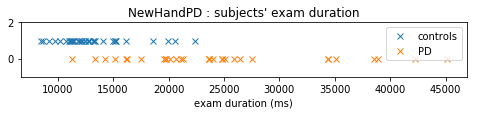

In [15]:
plt.figure(figsize=(8,1))
plt.title("NewHandPD : subjects' exam duration")
plt.plot(subjects_lengths[31:],[1 for _ in range(35)],'x',label="controls")
plt.plot(subjects_lengths[:31],[0 for _ in range(31)],'x',label="PD")
plt.ylim(-1,2)
#plt.xlim(10,100)
plt.xlabel("exam duration (ms)")
plt.legend()

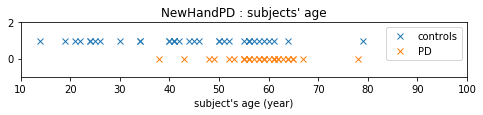

In [36]:
plt.figure(figsize=(8,1))
plt.title("NewHandPD : subjects' age")
plt.plot(subject_ages[31:],[1 for _ in range(35)],'x',label="controls")
plt.plot(subject_ages[:31],[0 for _ in range(31)],'x',label="PD")
plt.ylim(-1,2)
plt.xlim(10,100)
plt.xlabel("subject's age (year)")
plt.legend()

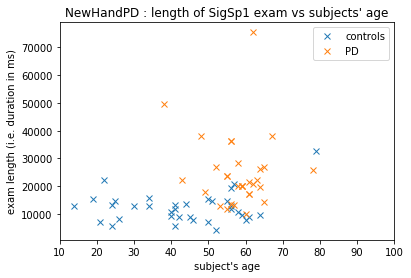

In [8]:
plt.title("NewHandPD : length of SigSp1 exam vs subjects' age")
plt.plot(subject_ages[31:],lengths[-4][31:],'x',label="controls")
plt.xlabel("subject's age")
plt.xlim(10,100)
plt.ylabel("exam length (i.e. duration in ms)")
plt.plot(subject_ages[:31],lengths[-4][:31],'x',label="PD")
plt.legend()

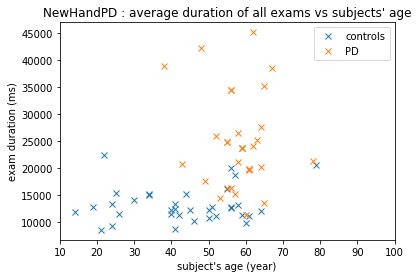

In [31]:
plt.title("NewHandPD : average duration of all exams vs subjects' age")
plt.plot(subject_ages[31:],subjects_lengths[31:],'x',label="controls")
plt.xlabel("subject's age (year)")
plt.xlim(10,100)
plt.ylabel("exam duration (ms)")
plt.plot(subject_ages[:31],subjects_lengths[:31],'x',label="PD")
plt.legend()

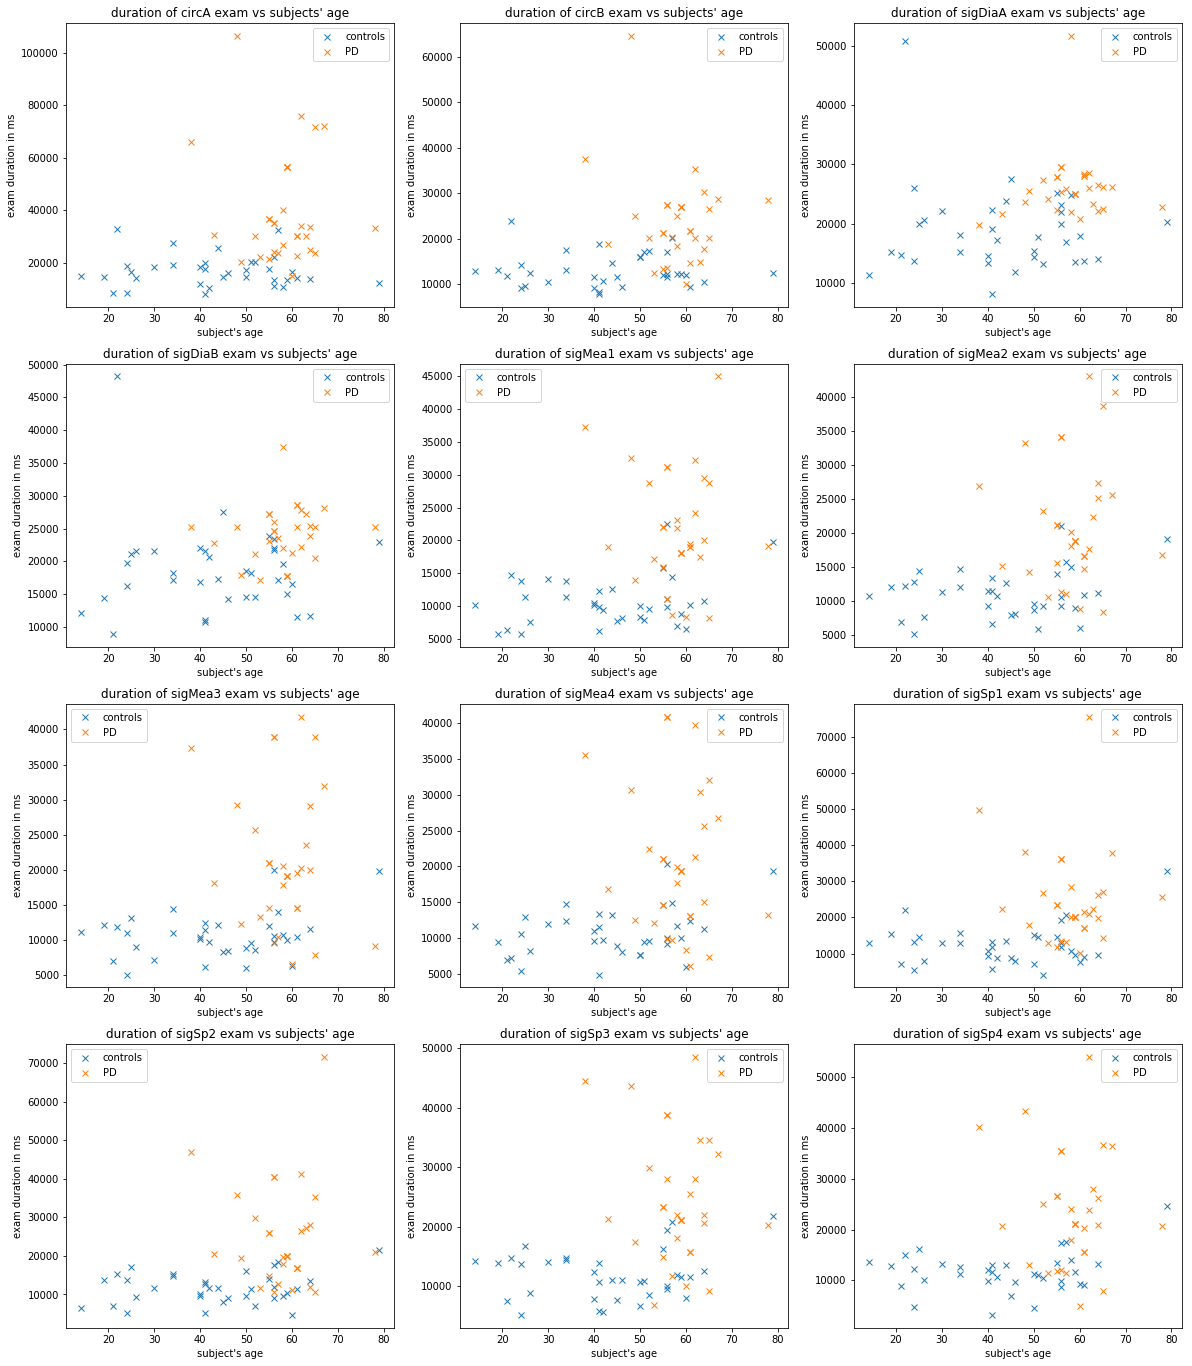

In [29]:

plt.figure(figsize=(20,24))
for i,task in enumerate(task_names):
    plt.subplot(4,3,i+1)
    plt.title("duration of {} exam vs subjects' age".format(task))
    plt.plot(subject_ages[31:],lengths[i][31:],'x',label="controls")
    plt.plot(subject_ages[:31],lengths[i][:31],'x',label="PD")
    plt.xlabel("subject's age")
    plt.ylabel("exam duration in ms")
    plt.legend()

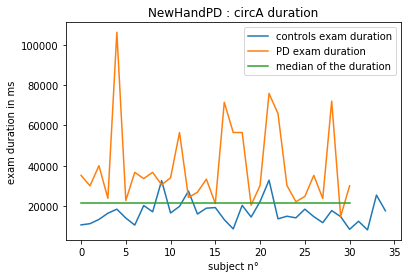

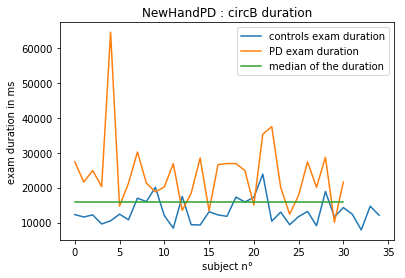

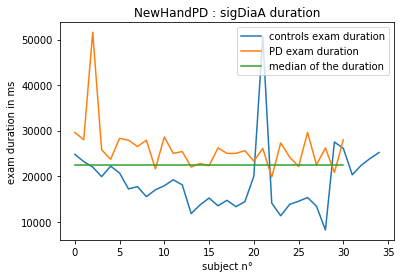

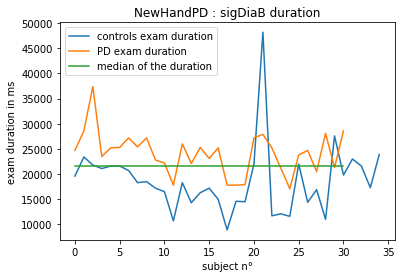

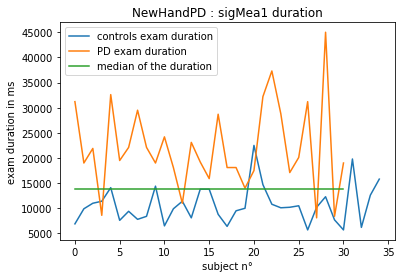

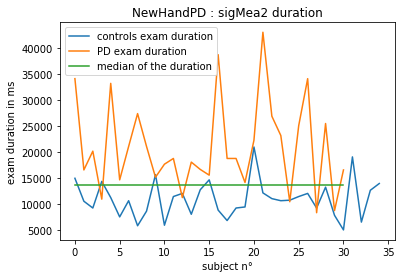

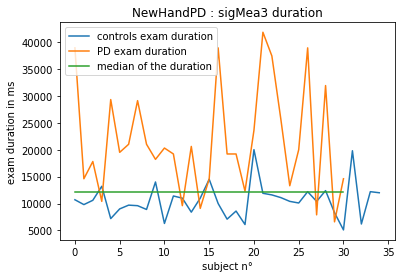

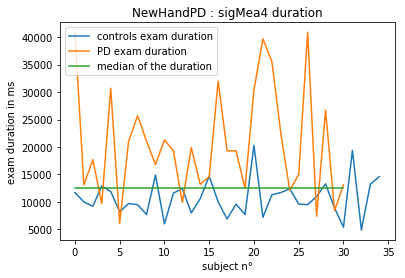

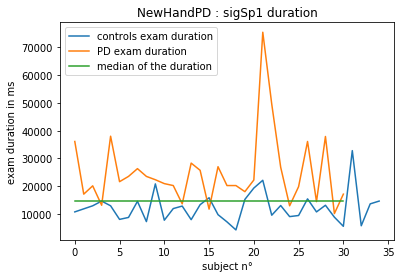

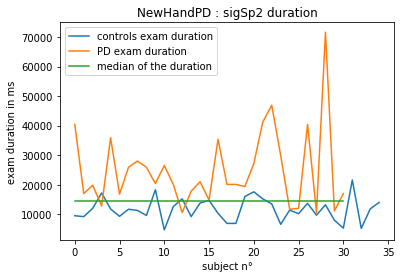

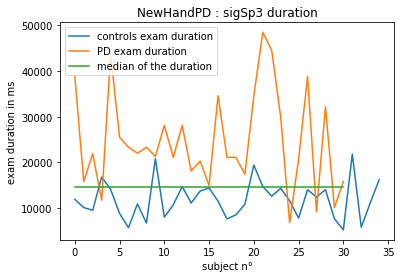

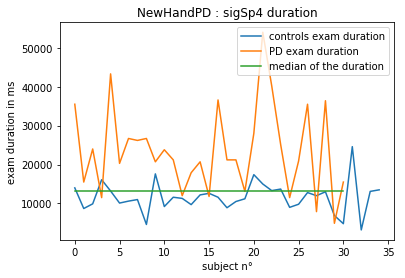

In [12]:

plt.figure()
for i,task in enumerate(task_names):
    plt.title("NewHandPD : {} duration".format(task))
    plt.plot(lengths[i][31:],label="controls exam duration")
    plt.plot(lengths[i][:31],label="PD exam duration")
    plt.plot([np.median(lengths[i]) for _ in range(31)],label="median of the duration")
    plt.xlabel("subject n°")
    plt.ylabel("exam duration in ms")
    plt.legend()

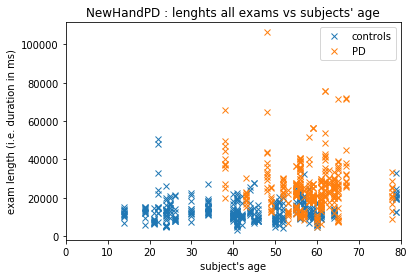

In [10]:
plt.title("NewHandPD : lenghts all exams vs subjects' age")
plt.plot(flat_ages[31*12:],flat_lengths[31*12:],'x',label="controls")
plt.xlabel("subject's age")
plt.xlim(0,80)
plt.ylabel("exam length (i.e. duration in ms)")
plt.plot(flat_ages[0:31*12],flat_lengths[0:31*12],'x',label="PD")
plt.legend()

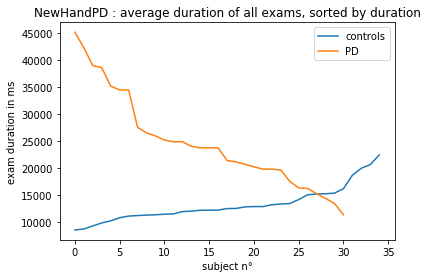

In [9]:
plt.title("NewHandPD : average duration of all exams, sorted by duration".format(task))
plt.plot(sorted(subjects_lengths[31:]),label="controls")
plt.plot(sorted(subjects_lengths[:31],reverse=True),label="PD")
#plt.plot([np.median(subjects_lengths) for _ in range(31)],label="median of the average duration")
plt.xlabel("subject n°")
plt.ylabel("exam duration in ms")
plt.legend()

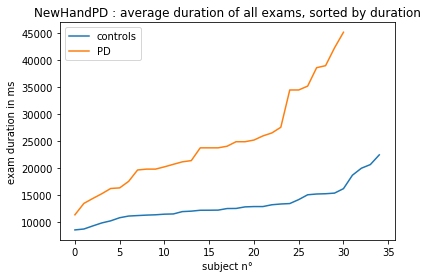

In [13]:
plt.title("NewHandPD : average duration of all exams, sorted by duration".format(task))
plt.plot(sorted(subjects_lengths[31:]),label="controls")
plt.plot(sorted(subjects_lengths[:31]),label="PD")
#plt.plot([np.median(subjects_lengths) for _ in range(31)],label="median of the average duration")
plt.xlabel("subject n°")
plt.ylabel("exam duration in ms")
plt.legend()

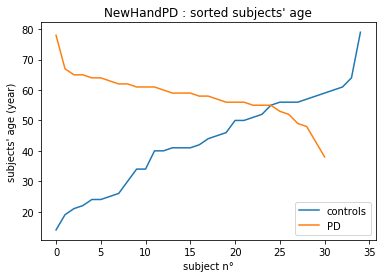

In [11]:
plt.title("NewHandPD : sorted subjects' age")
plt.plot(sorted(subject_ages[31:]),label="controls")
plt.plot(sorted(subject_ages[:31],reverse=True),label="PD")
#plt.plot([np.median(subjects_lengths) for _ in range(31)],label="median of the average duration")
plt.xlabel("subject n°")
plt.ylabel("subjects' age (year)")
plt.legend()

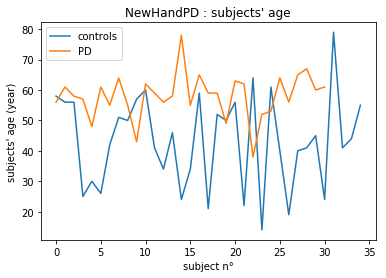

In [12]:
plt.title("NewHandPD : subjects' age")
plt.plot(subject_ages[31:],label="controls")
plt.plot(subject_ages[:31],label="PD")
#plt.plot([np.median(subjects_lengths) for _ in range(31)],label="median of the average duration")
plt.xlabel("subject n°")
plt.ylabel("subjects' age (year)")
plt.legend()

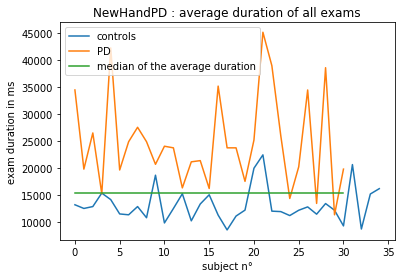

In [13]:
plt.title("NewHandPD : average duration of all exams".format(task))
plt.plot(subjects_lengths[31:],label="controls")
plt.plot(subjects_lengths[:31],label="PD")
plt.plot([np.median(subjects_lengths) for _ in range(31)],label="median of the average duration")
plt.xlabel("subject n°")
plt.ylabel("exam duration in ms")
plt.legend()

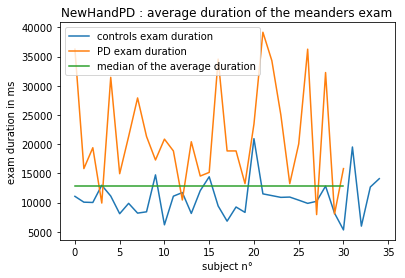

In [11]:
plt.title("NewHandPD : average duration of the meanders exam".format(task))
plt.plot(np.mean(meanders_lengths,axis=0)[31:],label="controls exam duration")
plt.plot(np.mean(meanders_lengths,axis=0)[:31],label="PD exam duration")
plt.plot([np.median(np.mean(meanders_lengths,axis=0)) for _ in range(31)],label="median of the average duration")
plt.xlabel("subject n°")
plt.ylabel("exam duration in ms")
plt.legend()

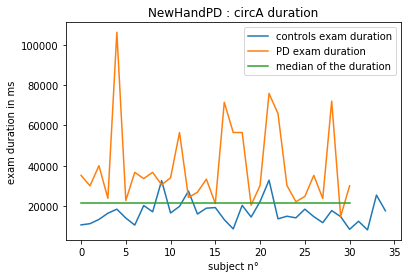

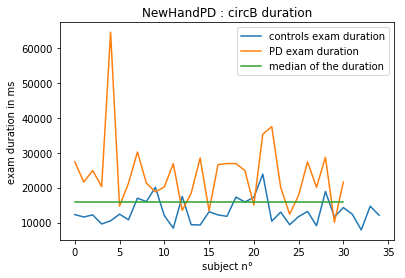

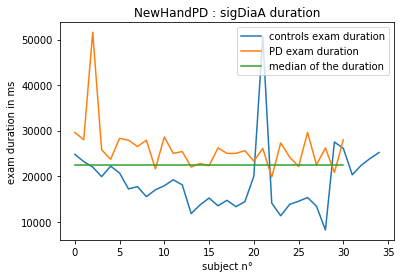

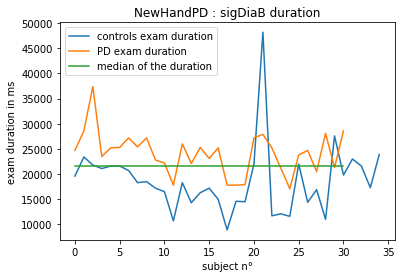

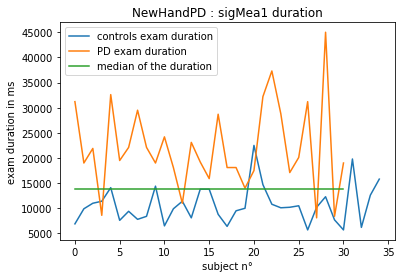

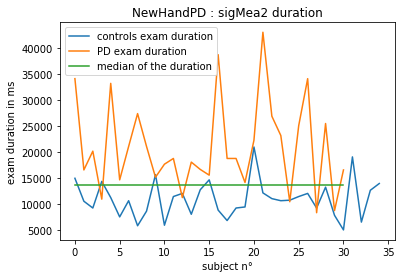

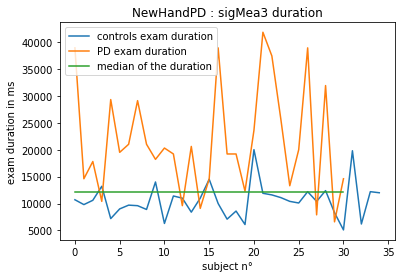

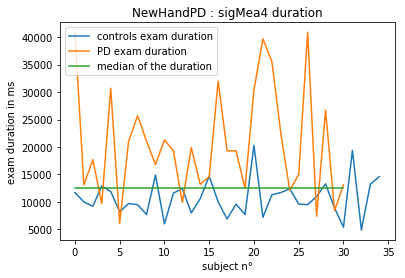

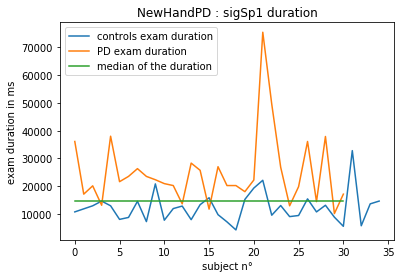

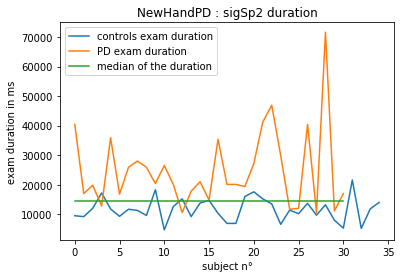

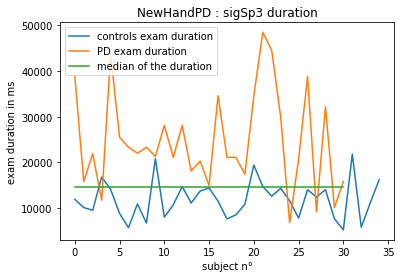

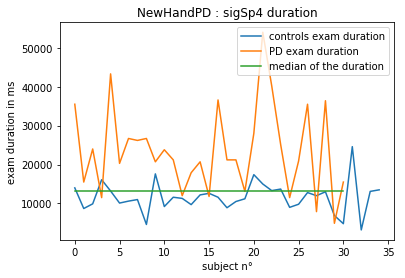

In [12]:
for i,task in enumerate(task_names):
    plt.figure()
    plt.title("NewHandPD : {} duration".format(task))
    plt.plot(lengths[i][31:],label="controls exam duration")
    plt.plot(lengths[i][:31],label="PD exam duration")
    plt.plot([np.median(lengths[i]) for _ in range(31)],label="median of the duration")
    plt.xlabel("subject n°")
    plt.ylabel("exam duration in ms")
    plt.legend()

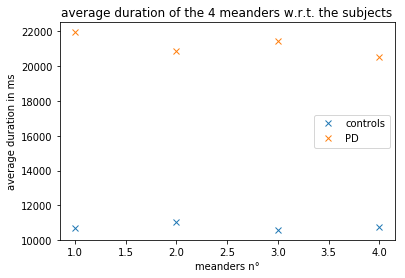

In [377]:
plt.title("average duration of the 4 meanders w.r.t. the subjects")
plt.ylabel("average duration in ms")
plt.plot([1,2,3,4],np.mean(np.asarray(meanders_lengths)[:,31:],axis=1),'x',label="controls")
plt.plot([1,2,3,4],np.mean(np.asarray(meanders_lengths)[:,:31],axis=1),'x',label="PD")
plt.xlabel("meanders n°")
plt.legend()

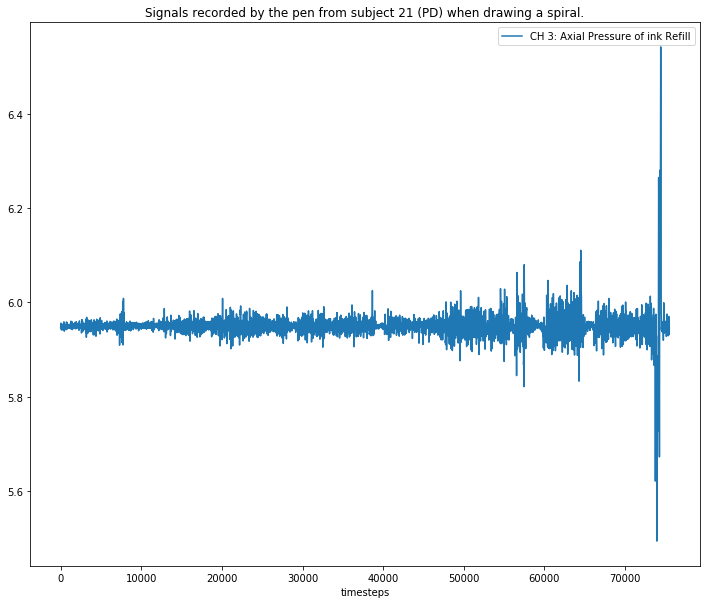

In [88]:
index=np.random.randint(0,len(data))
plt.figure(figsize=(12,10))
pd_control="PD" if targets[index] == 1 else "Control"
plt.title("Signals recorded by the pen from subject {} ({}) when drawing a spiral.".format(index,pd_control))
plt.xlabel("timesteps")
for i in [2]:
    plt.plot(data[index][:,i],label=index2measure[i])
    plt.legend()

Text(0.5,1,'Tilt and Acceleration in X VS Y direction')

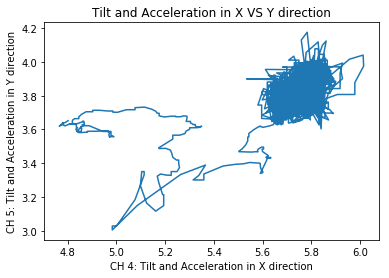

In [54]:
plt.plot(task[:,3],task[:,4])
plt.xlabel(index2measure[3])
plt.ylabel(index2measure[4])
plt.title("Tilt and Acceleration in X VS Y direction")